In [1]:
import os
import scipy.io
import numpy as np
from scipy import signal

data_path = "/kaggle/input/control1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')

for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []

for control_data_path in control_data:
    n_epochs = 70 
    start_epoch = 1
    end_epoch = 110

    control_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = os.path.join(control_data_path, f"trial{i}.mat")
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        f0 = 60 
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.lfilter(b, a, mat_data1)
        
        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        control_arr.append(downsampled_data)
        Control30.append(downsampled_data)

Control30 = np.array(Control30)

print(Control30.shape)

(3300, 60, 1000)


In [2]:
import os
import scipy.io
import numpy as np
from scipy import signal
data_path = "/kaggle/input/concussed1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)
    
Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 70
    start_epoch = 1
    end_epoch = 110
    concussed_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        f0 = 60 
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.lfilter(b, a, mat_data1)
        
        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
        Concussed52.append(downsampled_data)

Concussed52 = np.array(Concussed52)

print( Concussed52.shape)


(5390, 60, 1000)


In [3]:
import numpy as np
num_control = Control30.shape[0]
num_concussed = Concussed52.shape[0]

desired_num_control = num_concussed
num_oversampling = desired_num_control // num_control
oversampled_control = np.repeat(Control30, num_oversampling, axis=0)

num_additional_samples = desired_num_control - oversampled_control.shape[0]
additional_control_indices = np.random.choice(num_control, size=num_additional_samples, replace=True)
additional_control = Control30[additional_control_indices]
Control30= np.concatenate([oversampled_control,additional_control],axis=0)


In [4]:
from scipy.stats import entropy

alpha_band = (8, 12)
beta_band = (12, 35)
delta_band = (.5, 4)
epsilon = 1e-10

Control_feature = np.zeros((Control30.shape[0], Control30.shape[1], Control30.shape[2] + 4))

for i in range(Control30.shape[0]):
    for j in range(Control30.shape[1]):
        channel_data = Control30[i, j, :]
        freq_spectrum = np.fft.fft(channel_data)
        power_spectrum = np.abs(freq_spectrum) ** 2

        alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
        delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

        channel_min_value = np.min(channel_data)
        channel_max_value = np.max(channel_data)

        power_spectrum_adjusted = power_spectrum + epsilon
        entropy_values = entropy(power_spectrum_adjusted)
        values = np.array([alpha_power, beta_power, delta_power, entropy_values])
        rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value
        concatenated_data = np.concatenate((channel_data, rescaled_values))

        Control_feature[i, j, :-4] = channel_data
        Control_feature[i, j, -4:] = rescaled_values

print(Control_feature.shape)


(5390, 60, 1004)


In [5]:
from scipy.stats import entropy

alpha_band = (8, 12)
beta_band = (12, 35)
delta_band = (.5, 4)
epsilon = 1e-10

Concussed_feature = np.zeros((Concussed52.shape[0], Concussed52.shape[1], Concussed52.shape[2] + 4))

for i in range(Concussed52.shape[0]):
    for j in range(Concussed52.shape[1]):
        channel_data = Concussed52[i, j, :]
        freq_spectrum = np.fft.fft(channel_data)
        power_spectrum = np.abs(freq_spectrum) ** 2

        alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
        delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

        channel_min_value = np.min(channel_data)
        channel_max_value = np.max(channel_data)

        power_spectrum_adjusted = power_spectrum + epsilon
        entropy_values = entropy(power_spectrum_adjusted)
        values = np.array([alpha_power, beta_power, delta_power, entropy_values])
        rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value
        concatenated_data = np.concatenate((channel_data, rescaled_values))

        Concussed_feature[i, j, :-4] = channel_data
        Concussed_feature[i, j, -4:] = rescaled_values

print(Concussed_feature.shape)


(5390, 60, 1004)


In [6]:
dataset = np.concatenate((Control_feature, Concussed_feature), axis=0)
labels = np.concatenate((np.zeros(Control_feature.shape[0]), np.ones(Concussed_feature.shape[0])))
print(dataset.shape) 
print(labels.shape) 


(10780, 60, 1004)
(10780,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(60,1004)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=100, batch_size=32)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/100
270/270 [==============================] - 7s 22ms/step - loss: 0.6608 - accuracy: 0.6134
Epoch 2/100
270/270 [==============================] - 6s 23ms/step - loss: 0.5337 - accuracy: 0.7256
Epoch 3/100
270/270 [==============================] - 6s 21ms/step - loss: 0.4633 - accuracy: 0.7826
Epoch 4/100
270/270 [==============================] - 6s 22ms/step - loss: 0.3579 - accuracy: 0.8407
Epoch 5/100
270/270 [==============================] - 6s 21ms/step - loss: 0.3189 - accuracy: 0.8656
Epoch 6/100
270/270 [==============================] - 6s 21ms/step - loss: 0.2308 - accuracy: 0.9077
Epoch 7/100
270/270 [==============================] - 6s 22ms/step - loss: 0.1963 - accuracy: 0.9268
Epoch 8/100
270/270 [==============================] - 6s 22ms/step - loss: 0.1578 - accuracy: 0.9414
Epoch 9/100
270/270 [==============================] - 6s 22ms/step - loss: 0.1064 - accuracy: 0.9625
Epoch 10/100
270/270 [==============================] - 6s 22ms/step - loss: 0.310

In [10]:
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100))

68/68 [==============================] - 1s 9ms/step - loss: 0.8790 - accuracy: 0.9063
Accuracy: 90.63%


In [11]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


68/68 [==============================] - 1s 8ms/step
Confusion Matrix:
[[985  95]
 [107 969]]


In [12]:
from sklearn.metrics import classification_report
target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Control       0.90      0.91      0.91      1080
   Concussed       0.91      0.90      0.91      1076

    accuracy                           0.91      2156
   macro avg       0.91      0.91      0.91      2156
weighted avg       0.91      0.91      0.91      2156



Classification Report:
              precision    recall  f1-score   support

     Control       0.90      0.91      0.91      1080
   Concussed       0.91      0.90      0.91      1076

    accuracy                           0.91      2156
   macro avg       0.91      0.91      0.91      2156
weighted avg       0.91      0.91      0.91      2156



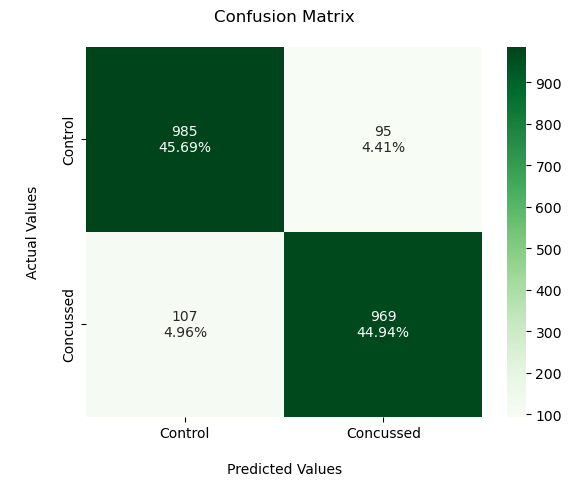

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

ax = sns.heatmap(cm, fmt='', annot=labels, cmap='Greens')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values\n')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

X_test_norm = (X_test - mean) / std
y_pred_prob = model.predict(X_test_norm)

y_pred_prob_positive = y_pred_prob[:, 0]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_positive)
roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
TP = 1030
FN = 48
FP = 96
TN = 982

Precision = TP / (TP + FP)
Sensitivity = TP / (TP + FN)
Specificity = TN /(TN + FP)
False_Pos_Rate = FP / (TN + FP)
False_Neg_Rate = FN / (FN + TP)
F1_Score = (2*Precision*Sensitivity) / (Precision + Sensitivity)
Accuracy = (TP+TN) / (TP+FP+TN+FN)

precision = "{:.2f}".format(Precision)
sensitivity = "{:.2f}".format(Sensitivity)
specificity = "{:.2f}".format(Specificity)
false_pos_rate = "{:.2f}".format(False_Pos_Rate)
false_neg_rate = "{:.2f}".format(False_Neg_Rate)
f1_score = "{:.2f}".format(F1_Score)
accuracy = "{:.2f}".format(Accuracy)

print("Precision          :", precision)
print("Sensitivity        :", sensitivity)
print("Specificity        :", specificity)
print("F1-Score           :", f1_score)
print("False Positive Rate:", false_pos_rate)
print("False Negative Rate:", false_neg_rate)
print("Accuraccy          :", accuracy)